#貸款用戶特徵分析

##基礎資料分析


###資料載入

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
file_path = "/content/Bank_Personal_Loan_Modelling.xlsx"
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name="Data")

In [3]:
print(df)

        ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  \
0        1   25           1      49     91107       4    1.6          1   
1        2   45          19      34     90089       3    1.5          1   
2        3   39          15      11     94720       1    1.0          1   
3        4   35           9     100     94112       1    2.7          2   
4        5   35           8      45     91330       4    1.0          2   
...    ...  ...         ...     ...       ...     ...    ...        ...   
4995  4996   29           3      40     92697       1    1.9          3   
4996  4997   30           4      15     92037       4    0.4          1   
4997  4998   63          39      24     93023       2    0.3          3   
4998  4999   65          40      49     90034       3    0.5          2   
4999  5000   28           4      83     92612       3    0.8          1   

      Mortgage  Personal Loan  Securities Account  CD Account  Online  \
0            0            

###檢查重複值

In [4]:
duplicate_rows = df.duplicated().sum()

In [5]:
print(f"重複值數量: {duplicate_rows}")

重複值數量: 0


###檢查缺失值

In [6]:
missing_values = df.isnull().sum()

In [7]:
print(f"缺失值數量:\n{missing_values}")

缺失值數量:
ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64


###檢查是否有異常負值

Zip Code格式檢查

In [8]:
zip_code_validity = df["ZIP Code"].astype(str).apply(lambda x: len(x) == 5 and x.isdigit())

In [9]:
print(zip_code_validity.value_counts())

ZIP Code
True     4999
False       1
Name: count, dtype: int64


刪除異常值

In [10]:
invalid_zip_code_row = df[~df["ZIP Code"].astype(str).apply(lambda x: len(x) == 5 and x.isdigit())]
df_cleaned = df[~df.index.isin(invalid_zip_code_row.index)].copy()
zip_code_validity_after = df_cleaned["ZIP Code"].astype(str).apply(lambda x: len(x) == 5 and x.isdigit()).all()
zip_code_validity_after, df_cleaned.shape

(np.True_, (4999, 14))

貸款數額異常值檢查

In [11]:
negative_loan_values = df_cleaned[df_cleaned["Personal Loan"] < 0]
negative_loan_values.count()

,0
ID,0
Age,0
Experience,0
Income,0
ZIP Code,0
Family,0
CCAvg,0
Education,0
Mortgage,0
Personal Loan,0


檢查 Experience 是否有負數

In [12]:
experience_anomalies = df[df["Experience"] < 0]

In [13]:
experience_anomalies

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
89,90,25,-1,113,94303,4,2.300000,3,0,0,0,0,0,1
226,227,24,-1,39,94085,2,1.700000,2,0,0,0,0,0,0
315,316,24,-2,51,90630,3,0.300000,3,0,0,0,0,1,0
451,452,28,-2,48,94132,2,1.750000,3,89,0,0,0,1,0
524,525,24,-1,75,93014,4,0.200000,1,0,0,0,0,1,0
536,537,25,-1,43,92173,3,2.400000,2,176,0,0,0,1,0
540,541,25,-1,109,94010,4,2.300000,3,314,0,0,0,1,0
576,577,25,-1,48,92870,3,0.300000,3,0,0,0,0,0,1
583,584,24,-1,38,95045,2,1.700000,2,0,0,0,0,1,0
597,598,24,-2,125,92835,2,7.200000,1,0,0,1,0,0,1


發現工作經驗的異常值發生在20到29歲之間,由於數據本身較少,運用中位數補齊該數據,減少極端值並且為值數據穩定

In [14]:
median_experience_20s = df_cleaned[(df_cleaned["Age"] >= 20) & (df_cleaned["Age"] <= 29) & (df_cleaned["Experience"] >= 0)]["Experience"].median()
df_cleaned.loc[(df_cleaned["Age"] >= 20) & (df_cleaned["Age"] <= 29) & (df_cleaned["Experience"] < 0), "Experience"] = median_experience_20s
experience_anomalies_after = df_cleaned[df_cleaned["Experience"] < 0]

experience_anomalies_after.count()

,0
ID,0
Age,0
Experience,0
Income,0
ZIP Code,0
Family,0
CCAvg,0
Education,0
Mortgage,0
Personal Loan,0


###調整CCAVG的時間跨度(月轉年)

In [15]:
df["CCAvg_Annual"] = df["CCAvg"] * 12
df[["CCAvg", "CCAvg_Annual", "Income"]].head()

,CCAvg,CCAvg_Annual,Income
0,1.6,19.2,49
1,1.5,18.0,34
2,1.0,12.0,11
3,2.7,32.4,100
4,1.0,12.0,45


###信用卡消費佔年度收入比

In [16]:
df["Credit_Usage_Ratio"] = df["CCAvg_Annual"] / df["Income"]

In [17]:
df["Credit_Usage_Ratio"]

,Credit_Usage_Ratio
0,0.391837
1,0.529412
2,1.090909
3,0.324000
4,0.266667
...,...
4995,0.570000
4996,0.320000
4997,0.150000
4998,0.122449


 ###Mortgage 的峰度

In [18]:
mortgage_kurtosis = kurtosis(df["Mortgage"], fisher=True)

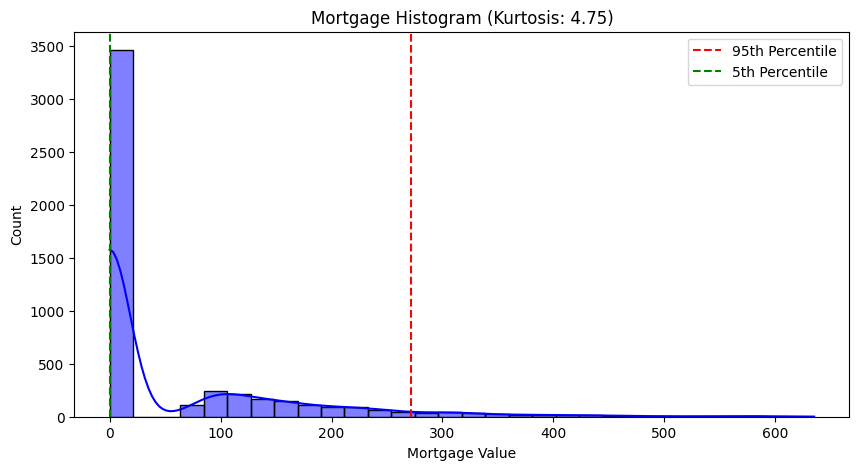

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Mortgage"], bins=30, kde=True, color='blue')
plt.axvline(np.percentile(df["Mortgage"], 95), color='red', linestyle='dashed', label="95th Percentile")
plt.axvline(np.percentile(df["Mortgage"], 5), color='green', linestyle='dashed', label="5th Percentile")
plt.xlabel("Mortgage Value")
plt.ylabel("Count")
plt.title(f"Mortgage Histogram (Kurtosis: {mortgage_kurtosis:.2f})")
plt.legend()
plt.show()

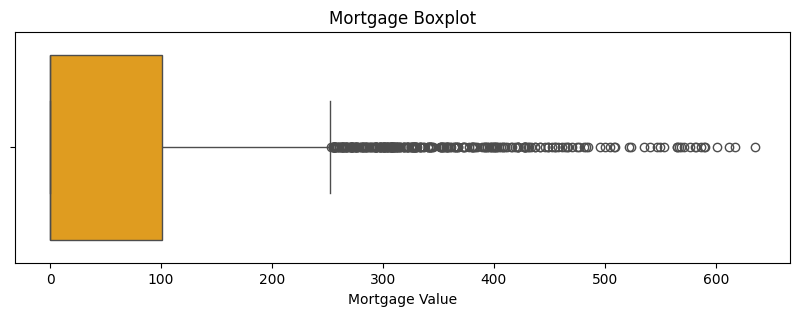

In [20]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=df["Mortgage"], color='orange')
plt.xlabel("Mortgage Value")
plt.title("Mortgage Boxplot")
plt.show()


In [21]:
high_mortgage_threshold = np.percentile(df["Mortgage"], 95)
df["High_Mortgage"] = (df["Mortgage"] >= high_mortgage_threshold).astype(int)

df["High_Mortgage"].value_counts()

,count
High_Mortgage,
0,4748
1,252


###共線性問題檢驗

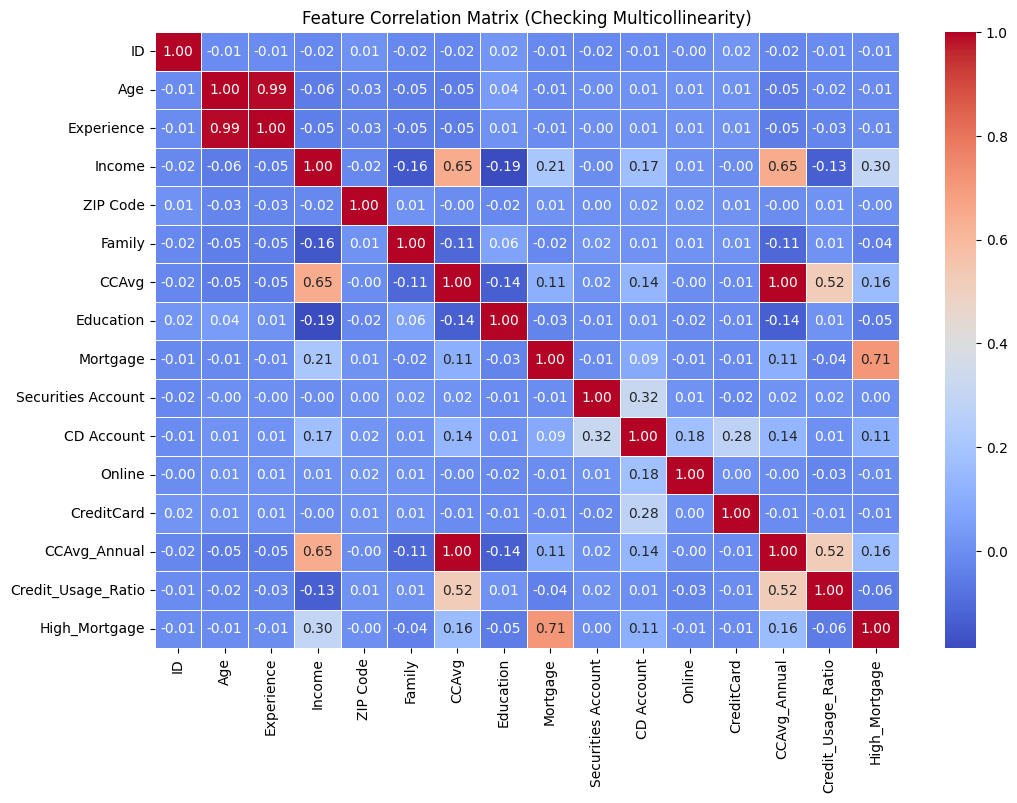

In [22]:
Z = df.drop(columns=["Personal Loan"])
correlation_matrix = Z.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix (Checking Multicollinearity)")
plt.show()


In [23]:
high_corr_features = [(col1, col2, correlation_matrix.loc[col1, col2])
                      for col1 in correlation_matrix.columns
                      for col2 in correlation_matrix.columns
                      if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.75]

high_corr_features

[('Age', 'Experience', np.float64(0.9942148569683337)),
 ('Experience', 'Age', np.float64(0.9942148569683337)),
 ('CCAvg', 'CCAvg_Annual', np.float64(0.999999999999993)),
 ('CCAvg_Annual', 'CCAvg', np.float64(0.999999999999993))]

選擇AGE,因為經驗與年齡高度相關可能造成共憲性問題,最後選用age是因為更為值觀且在貸款審核時工作經驗是有可能伪造的


In [24]:
df.drop(columns=["Experience"], inplace=True)

In [25]:
df.drop(columns=["CCAvg"], inplace=True)

##特徵分析

標籤分離

In [26]:
X = df.drop(columns=["Personal Loan"])
y = df["Personal Loan"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




Smote 修正訓練資料比例失衡比例問題

In [27]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_train_resampled_series = pd.Series(y_train_resampled)
loan_counts_after_smote = y_train_resampled_series.value_counts(normalize=True) * 100
print("SMOTE 過採樣後的 Personal Loan 分佈：")
print(loan_counts_after_smote)

SMOTE 過採樣後的 Personal Loan 分佈：
Personal Loan
0    50.0
1    50.0
Name: proportion, dtype: float64


###線性特徵分析模型

####邏輯回歸模型

In [28]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

####決策樹模型

In [29]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

###非線性特徵分析模型

####隨機森林模型

In [30]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

####SVM模型

In [31]:
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train_resampled, y_train_resampled)

SVC(kernel='linear', probability=True, random_state=42)

###特徵重要性檢驗

In [32]:
log_reg_coef = np.abs(log_reg.coef_).flatten()
tree_feature_importance = tree_clf.feature_importances_
rf_feature_importance = rf_clf.feature_importances_

In [33]:
feature_names = X_train.columns

In [34]:
print(feature_names)

Index(['ID', 'Age', 'Income', 'ZIP Code', 'Family', 'Education', 'Mortgage',
       'Securities Account', 'CD Account', 'Online', 'CreditCard',
       'CCAvg_Annual', 'Credit_Usage_Ratio', 'High_Mortgage'],
      dtype='object')


In [35]:
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Logistic_Regression": log_reg_coef,
    "Decision_Tree": tree_feature_importance,
    "Random_Forest": rf_feature_importance
}).set_index("Feature")

In [36]:
print(feature_importance_df)

                    Logistic_Regression  Decision_Tree  Random_Forest
Feature                                                              
ID                             0.000105       0.021764       0.027705
Age                            0.002101       0.026233       0.029597
Income                         0.052308       0.657579       0.401951
ZIP Code                       0.000085       0.020719       0.027507
Family                         0.079196       0.078956       0.046416
Education                      1.084307       0.062247       0.057517
Mortgage                       0.001567       0.008320       0.020615
Securities Account             0.306259       0.001049       0.004958
CD Account                     0.420077       0.002097       0.010311
Online                         0.921734       0.002709       0.014461
CreditCard                     0.912372       0.006877       0.022518
CCAvg_Annual                   0.022164       0.072318       0.248545
Credit_Usage_Ratio  

###模型評估

In [37]:
models = {
    "Logistic Regression": log_reg,
    "Decision Tree": tree_clf,
    "Random Forest": rf_clf,
    "SVM": svm_clf
}

accuracy_results = {}
classification_reports = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results[name] = accuracy
    classification_reports[name] = classification_report(y_test, y_pred, output_dict=True)


In [38]:
print("特徵重要性比較：")
print(feature_importance_df)


特徵重要性比較：
                    Logistic_Regression  Decision_Tree  Random_Forest
Feature                                                              
ID                             0.000105       0.021764       0.027705
Age                            0.002101       0.026233       0.029597
Income                         0.052308       0.657579       0.401951
ZIP Code                       0.000085       0.020719       0.027507
Family                         0.079196       0.078956       0.046416
Education                      1.084307       0.062247       0.057517
Mortgage                       0.001567       0.008320       0.020615
Securities Account             0.306259       0.001049       0.004958
CD Account                     0.420077       0.002097       0.010311
Online                         0.921734       0.002709       0.014461
CreditCard                     0.912372       0.006877       0.022518
CCAvg_Annual                   0.022164       0.072318       0.248545
Credit_Usag

In [39]:
print("\n模型準確度比較：")
print(accuracy_results)


模型準確度比較：
{'Logistic Regression': 0.867, 'Decision Tree': 0.955, 'Random Forest': 0.968, 'SVM': 0.858}


##數據可視化

In [40]:
sns.set(style="whitegrid")

###收入分佈比較

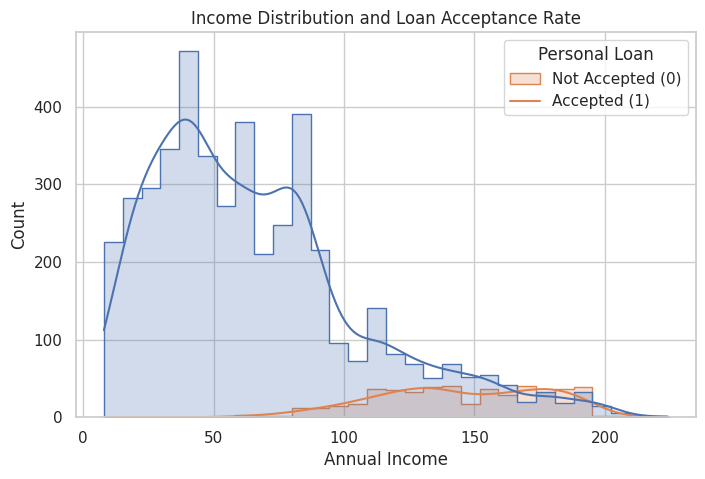

In [41]:
plt.figure(figsize=(8, 5))
sns.histplot(df, x="Income", hue="Personal Loan", kde=True, bins=30, element="step")
plt.title("Income Distribution and Loan Acceptance Rate")
plt.xlabel("Annual Income")
plt.ylabel("Count")
plt.legend(title="Personal Loan", labels=["Not Accepted (0)", "Accepted (1)"])
plt.show()

### 教育程度分佈比較

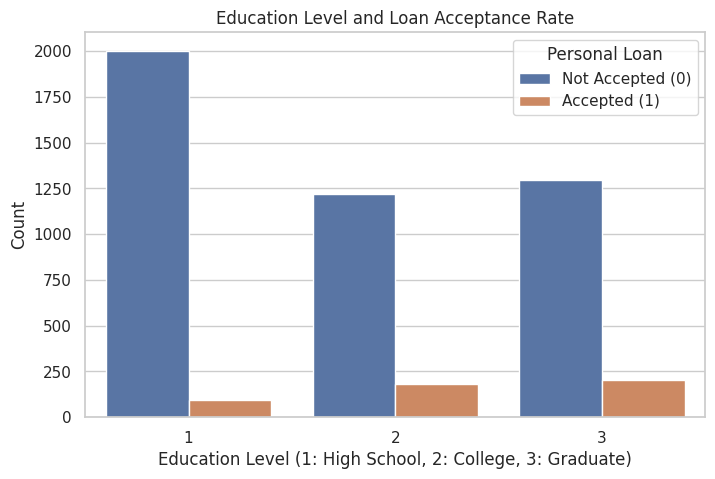

In [42]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Education", hue="Personal Loan")
plt.title("Education Level and Loan Acceptance Rate")
plt.xlabel("Education Level (1: High School, 2: College, 3: Graduate)")
plt.ylabel("Count")
plt.legend(title="Personal Loan", labels=["Not Accepted (0)", "Accepted (1)"])
plt.show()


###信用卡持有者 vs. 貸款接受率

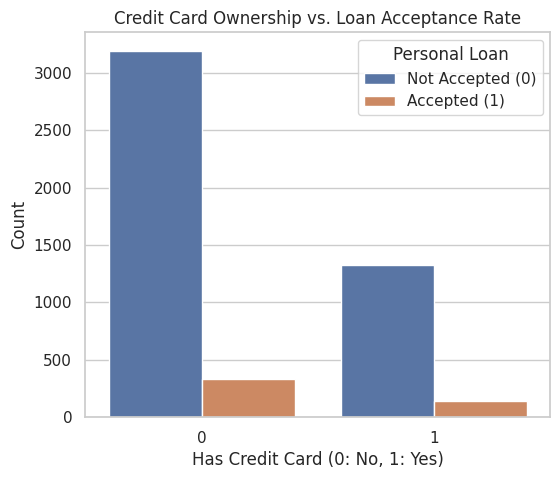

In [43]:
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x="CreditCard", hue="Personal Loan")
plt.title("Credit Card Ownership vs. Loan Acceptance Rate")
plt.xlabel("Has Credit Card (0: No, 1: Yes)")
plt.ylabel("Count")
plt.legend(title="Personal Loan", labels=["Not Accepted (0)", "Accepted (1)"])
plt.show()


### 持有 CD 帳戶 vs. 貸款接受率

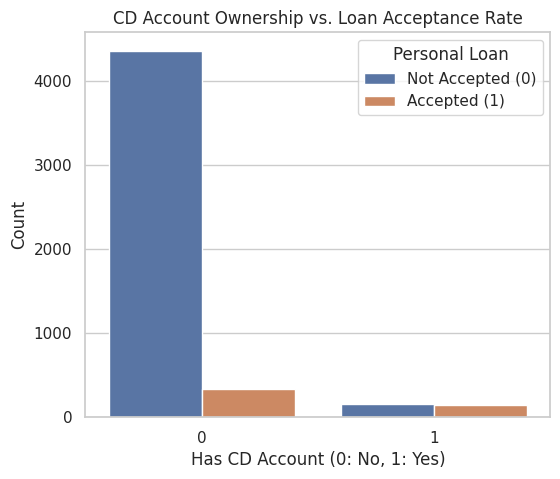

In [44]:
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x="CD Account", hue="Personal Loan")
plt.title("CD Account Ownership vs. Loan Acceptance Rate")
plt.xlabel("Has CD Account (0: No, 1: Yes)")
plt.ylabel("Count")
plt.legend(title="Personal Loan", labels=["Not Accepted (0)", "Accepted (1)"])
plt.show()

### 信用卡消費率 vs. 貸款接受率

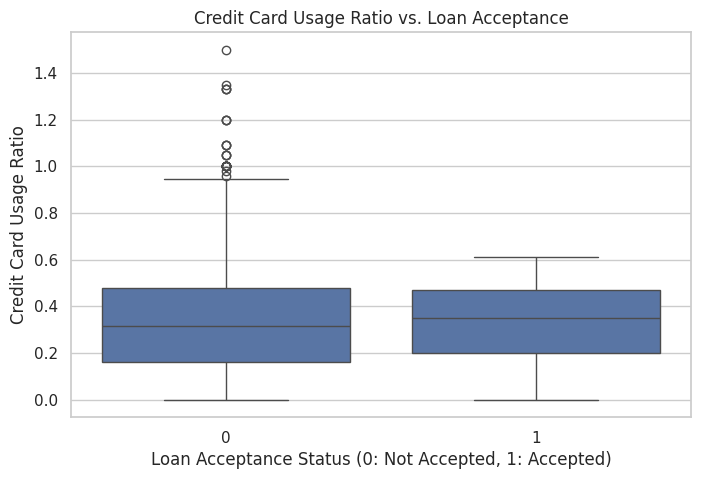

In [45]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Personal Loan", y="Credit_Usage_Ratio")
plt.title("Credit Card Usage Ratio vs. Loan Acceptance")
plt.xlabel("Loan Acceptance Status (0: Not Accepted, 1: Accepted)")
plt.ylabel("Credit Card Usage Ratio")
plt.show()

##潛在貸款者用戶描述

###K-Mean用戶分類

In [46]:
features_for_clustering = ["Income", "Education", "CreditCard", "CD Account", "High_Mortgage", "Online"]

missing_cols = [col for col in features_for_clustering if col not in df.columns]
if missing_cols:
    raise ValueError(f"❌ 缺少以下欄位：{missing_cols}")
else:
    print("✅ 所有必要欄位都存在！")

X_cluster = df[features_for_clustering].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

k_range = range(2, 11)
sse = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    sse.append(kmeans.inertia_)

    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

✅ 所有必要欄位都存在！


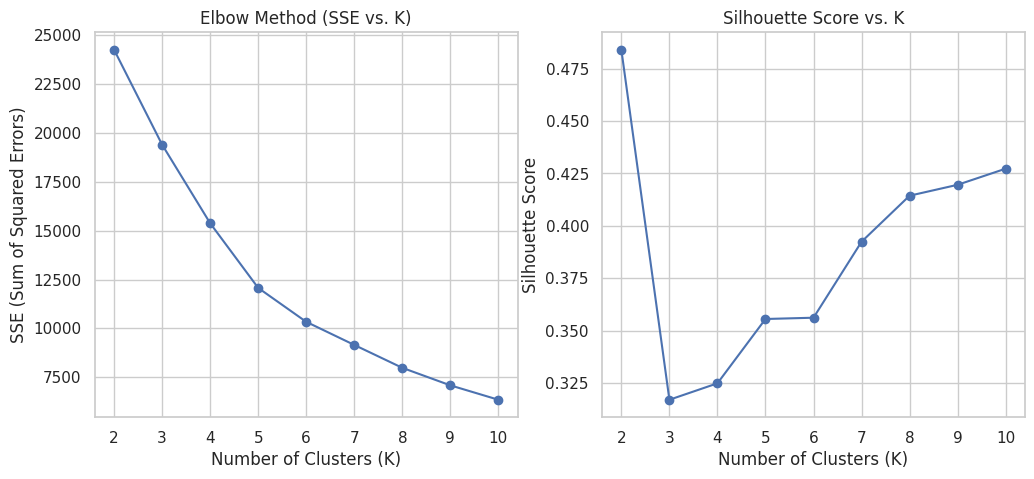

In [47]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Elbow Method (SSE vs. K)")

# 繪製 Silhouette Score vs. K
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. K")

plt.show()

K=5 是比較平衡的選擇：

Elbow Method：仍能降低 SSE，但不會過度增加群集數量。

Silhouette Score：在 K=5 開始回升，代表群集品質提升。

行銷應用：5 個群組仍然容易解釋，可以有效規劃貸款行銷策略。

###用戶描述

In [54]:
features_for_clustering = ["Income", "Education", "CreditCard", "CD Account", "High_Mortgage", "Online"]

X_cluster = df[features_for_clustering].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df.loc[X_cluster.index, "Cluster_4"] = kmeans.fit_predict(X_scaled)

cluster_summary_k4 = df.groupby("Cluster_4")[features_for_clustering].mean()

from IPython.display import display
display(cluster_summary_k4)

,Income,Education,CreditCard,CD Account,High_Mortgage,Online
Cluster_4,,,,,,
0.0,69.891450,1.901115,0.000000,0.000000,0.0,0.000000
1.0,69.949257,1.899539,0.000000,0.000000,0.0,1.000000
2.0,133.087302,1.686508,0.273810,0.174603,1.0,0.583333
3.0,97.945736,1.910853,0.802326,1.000000,0.0,0.937984
4.0,66.656616,1.862647,1.000000,0.000000,0.0,0.539363


In [56]:
loan_acceptance_summary = df.groupby("Cluster_4")["Personal Loan"].mean()

loan_acceptance_df = pd.DataFrame(loan_acceptance_summary).rename(columns={"Personal Loan": "Loan Acceptance Rate"})
display(loan_acceptance_df)

,Loan Acceptance Rate
Cluster_4,
0.0,0.077323
1.0,0.070733
2.0,0.349206
3.0,0.414729
4.0,0.036013


Cluster 2 跟 Cluster 3 的貸款接受率最高，這表示這兩個群組是最有可能成為貸款客戶的目標族群

Cluster 3：潛在高額貸款客群

特徵分析：

*   收入 (Income)：97.95K，屬於中高收入群體
*   教育程度 (Education)：1.91，接近大學教育水平
*   信用卡持有率 (CreditCard)：80.2% 擁有信用卡
*   定存帳戶 (CD Account)：100% 擁有定存帳戶
*   高額房貸 (High_Mortgage)：0%，幾乎無高額房貸
*   網路銀行使用率 (Online)：93.8%，非常依賴網路銀行
*   貸款接受率 (Loan Acceptance Rate)：41.47%，最高貸款接受率

可能的行為模式：

*   財務狀況穩定，具有高理財意識
*   高信用卡使用率，可能有較高消費習慣
*   偏好使用數位銀行服務，較少依賴實體銀行
*   無高額房貸，可能有較大的可支配收入
*   對貸款興趣高，可能尋求短期資金靈活性













Cluster 2：中高收入且適度貸款接受族群
特徵分析：

* 收入 (Income)：133.08K，屬於高收入群體
* 教育程度 (Education)：1.69，接近大學程度
* 信用卡持有率 (CreditCard)：27.3%，信用卡持有率較低
* 定存帳戶 (CD Account)：17.5%，部分擁有定存帳戶
* 高額房貸 (High_Mortgage)：100%，所有客戶都有高額房貸
* 網路銀行使用率 (Online)：58.3%，部分使用網銀
* 貸款接受率 (Loan Acceptance Rate)：34.92%，中高貸款接受率

可能的行為模式：

* 高收入，但較依賴房貸進行資產配置
* 信用卡持有率較低，可能傾向使用現金或銀行貸款
* 部分客戶擁有定存帳戶，代表對長期理財有一定興趣
* 網銀使用率中等，可能仍偏向傳統銀行服務
* 貸款接受率較高，代表對銀行貸款產品仍有需求

<ipython-input-57-48253405023d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loan_acceptance_df.index, y=loan_acceptance_df["Loan Acceptance Rate"], palette="viridis")


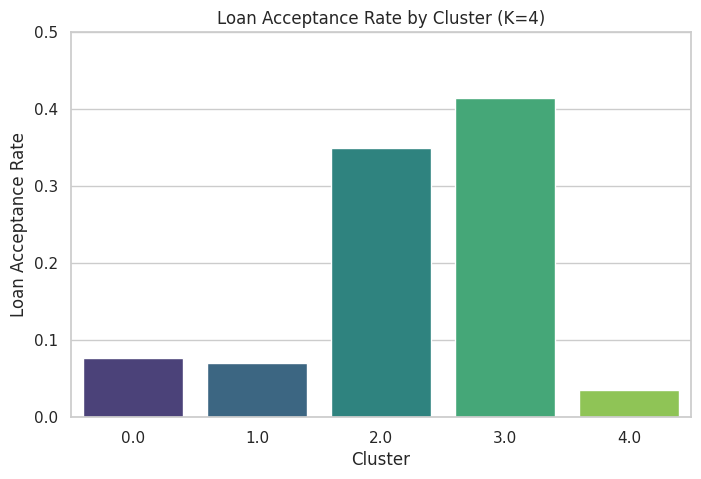

In [57]:
plt.figure(figsize=(8, 5))
sns.barplot(x=loan_acceptance_df.index, y=loan_acceptance_df["Loan Acceptance Rate"], palette="viridis")

plt.xlabel("Cluster")
plt.ylabel("Loan Acceptance Rate")
plt.title("Loan Acceptance Rate by Cluster (K=4)")
plt.ylim(0, 0.5)

plt.show()

###Cluster 2

In [66]:
cluster_2_data = df[df["Cluster_4"] == 2]

cluster_2_summary = cluster_2_data[["Age", "Income", "Education", "CreditCard", "CD Account", "Securities Account", "Credit_Usage_Ratio"]].mean()


detailed_cluster_2_analysis = pd.DataFrame({"Feature": cluster_2_summary.index, "Value": cluster_2_summary.values})
print("📊 Cluster 2 細分特徵：")
print(detailed_cluster_2_analysis)

📊 Cluster 2 細分特徵：
              Feature       Value
0                 Age   44.952381
1              Income  133.087302
2           Education    1.686508
3          CreditCard    0.273810
4          CD Account    0.174603
5  Securities Account    0.107143
6  Credit_Usage_Ratio    0.282445


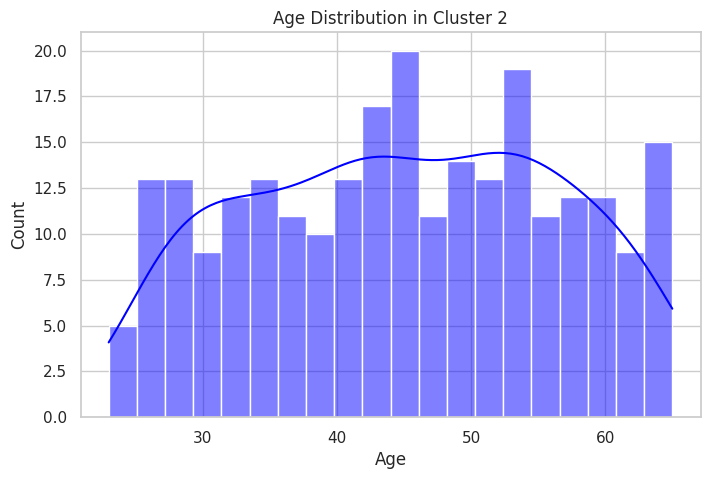

In [63]:
plt.figure(figsize=(8, 5))
sns.histplot(cluster_2_data["Age"], bins=20, kde=True, color="blue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution in Cluster 2")
plt.show()

行銷策略：

1. AI 推薦智能貸款組合

* 使用 ChatGPT / Gemini 分析客戶房貸與現金流，提供 「房貸+個人貸款」最佳組合方案
例如，對於高房貸但穩定收入的客戶，建議「低息貸款來補充資金流動性」
2. AI 個性化金融顧問

* AI 驅動的 Chatbot 可分析客戶財務數據，提供專屬貸款建議
* 整合語音 AI 助理，提供快速貸款咨詢服務（透過銀行 App 內建 Chatbot）
3. 金融 AI 廣告定向推播

* 透過 GenAI 生成動態廣告，主打「高額房貸靈活資金解決方案」
* 精準投放於房貸論壇、理財社群 & 金融新聞網站
4. 智能信用增值計畫

* 針對信用卡持有率低的問題，提供「房貸+信用卡」優惠綁定
*例如，「使用信用卡支付房貸部分金額，可享 1% 回饋」



###Cluster 3



In [68]:
cluster_3_data = df[df["Cluster_4"] == 3]

cluster_3_summary = cluster_3_data[["Age", "Income", "Education", "CreditCard", "CD Account", "Securities Account", "Credit_Usage_Ratio"]].mean()


detailed_cluster_3_analysis = pd.DataFrame({"Feature": cluster_3_summary.index, "Value": cluster_3_summary.values})
print("📊 Cluster 3 細分特徵：")
print(detailed_cluster_3_analysis)

📊 Cluster 3 細分特徵：
              Feature      Value
0                 Age  45.581395
1              Income  97.945736
2           Education   1.910853
3          CreditCard   0.802326
4          CD Account   1.000000
5  Securities Account   0.500000
6  Credit_Usage_Ratio   0.340459


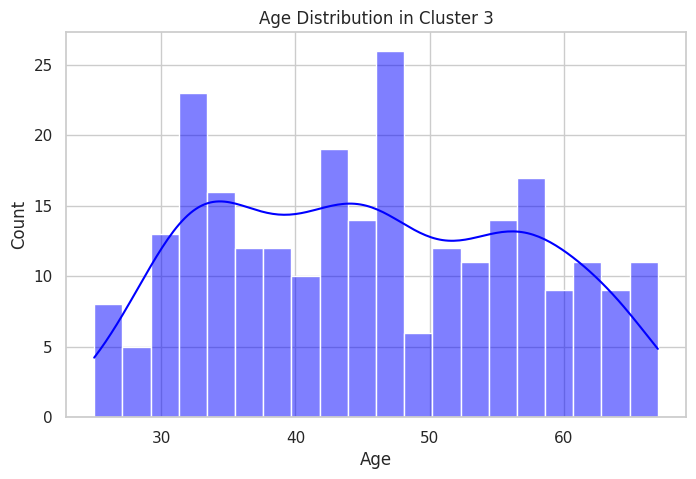

In [69]:
plt.figure(figsize=(8, 5))
sns.histplot(cluster_3_data["Age"], bins=20, kde=True, color="blue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution in Cluster 3")
plt.show()

行銷策略：

1. AI 驅動的智能存貸組合

* 透過 GenAI 生成個性化「高利率定存+低息貸款」方案
* 例如，「存款 50K 以上可獲得貸款利率折扣 0.5%」
2. AI 智能行銷推播

* 針對此群體的 高網銀使用率，透過 AI 聊天機器人自動推送專屬貸款優惠
* 例如，「您的理財風格適合高回饋定存貸款，點擊查看專屬方案」
3. 智能信用增值體驗

* 提供「信用貸款 + 高額信用卡」優惠組合，鼓勵客戶 開立高額信用卡提升信用額度
* GenAI 生成個性化信用額度提升方案，分析客戶財務狀況來優化貸款利率
4. AI 數據驅動再行銷

* 透過機器學習分析，篩選最可能接受貸款的客戶
* GenAI 生成「智能定存+貸款」模擬場景，幫助客戶計算理財收益